In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy

    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [30]:
def dpvc(X, labels):
    unique_clusters = set(labels) - {-1}  # Excluye ruido (-1)
    density_peaks = {}

    # 🔹 Paso 1: Calcular densidad local (usando k-vecinos más cercanos)
    k = 5  # Vecinos para densidad local
    dist_matrix = pairwise_distances(X)
    local_density = np.mean(np.sort(dist_matrix, axis=1)[:, 1:k+1], axis=1)

    # 🔹 Paso 2: Identificar picos de densidad por cluster
    for cluster in unique_clusters:
        cluster_points = X[labels == cluster]
        cluster_density = local_density[labels == cluster]
        density_peaks[cluster] = cluster_points[np.argmin(cluster_density)]

    # 🔹 Paso 3: Calcular DPVC para cada cluster
    dpvc_scores = []
    for cluster in unique_clusters:
        cluster_points = X[labels == cluster]
        peak = density_peaks[cluster]
        distances_to_peak = np.linalg.norm(cluster_points - peak, axis=1)
        score = np.mean(distances_to_peak)
        dpvc_scores.append(score)

    return np.mean(dpvc_scores)  # Promedio de los clusters

In [3]:
model_type = "AE"
identifier = "batch_size_14_num_hiddens_64_"
day = 4
hour = 9
date_format = f"day_{day}_hour_{hour}"

model_name = f"{root}/Zamuro/temporal_zamuro/models/log_standarization_model_epochs_10/model_{model_type}_{identifier}_{date_format}_final.pth"
model = AE(num_hiddens=64).to(device)
model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))

audios = pd.read_csv(f"Complementary_Files/zamuro_audios_complete.csv", index_col=0)
recorders = pd.read_csv(f"Complementary_Files/zamuro_recorders_satelites.csv", index_col=0)
df_ae = pd.read_csv(f"temporal_zamuro/Features/New_df_ae_unflat.csv")
X = np.asarray(df_ae.loc[:,"0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)
print(X.shape)


(53275, 5184)


In [ ]:
Normalizer_ = Normalizer().fit(X)
X_norm = Normalizer_.transform(X)

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [ ]:
X_TSNE = TSNE(n_components=2, learning_rate="auto", init='random', random_state=0).fit_transform(X)
X_TSNE_norm = TSNE(n_components=2, learning_rate="auto", init='random', random_state=0).fit_transform(X_norm)
X_TSNE_scaled = TSNE(n_components=2, learning_rate="auto", init='random', random_state=0).fit_transform(X_scaled)

X_TSNE_norm_norm = Normalizer().fit_transform(X_TSNE_norm_norm)
X_TSNE_norm_scaled = StandardScaler().fit_transform(X_TSNE_norm_scaled)


In [ ]:
mapper = umap.UMAP(n_components=2, min_dist=0.01,
                            metric="euclidean", n_neighbors=75,
                            random_state=0, n_jobs=-1).fit(X)
X_UMAP = mapper.transform(X)

mapper = umap.UMAP(n_components=2, min_dist=0.01,
                            metric="euclidean", n_neighbors=75,
                            random_state=0, n_jobs=-1).fit(X_norm)
X_UMAP_norm = mapper.transform(X_norm)

In [ ]:
from sklearn.preprocessing import LabelEncoder

y_hour = df_ae["hour"]
# y_hour = list(np.repeat(y_hour, 5))
y_cover = df_ae["cover"]
# y_cover = list(np.repeat(y_cover, 5))
y_site = df_ae["location"]
# y_site = list(np.repeat(y_site, 5))
y_stage = df_ae["hour_stage"]

encoder = LabelEncoder()
y_site = encoder.fit_transform(y_site)
y_cover = encoder.fit_transform(y_cover)
y_stage = encoder.fit_transform(y_stage)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

y_n = y_stage
labels = np.unique(y)
cmap = plt.get_cmap("inferno", len(labels))  # Cambia "viridis" por cualquier colormap que prefieras
norm = mcolors.BoundaryNorm(np.arange(len(labels) + 1) - 0.5, len(labels))
# Primer scatter plot

axes[0].scatter(X_TSNE[:, 0], X_TSNE[:, 1], s=0.1, alpha=0.1, c=y_n, cmap=cmap, norm=norm)
axes[0].set_title("Original TSNE")

# Segundo scatter plot
axes[1].scatter(X_TSNE_norm[:, 0], X_TSNE_norm[:, 1], s=0.1, alpha=0.1, c=y_n, cmap=cmap, norm=norm)
axes[1].set_title("Normalized TSNE")

# Tercer scatter plot
axes[2].scatter(X_TSNE_scaled[:, 0], X_TSNE_scaled[:, 1], s=0.1, alpha=0.1, c=y_n, cmap=cmap, norm=norm)
axes[2].set_title("Scaled TSNE")

# Ajustar diseño
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

y_n = y_stage
labels = np.unique(y)
cmap = plt.get_cmap("inferno", len(labels))  # Cambia "viridis" por cualquier colormap que prefieras
norm = mcolors.BoundaryNorm(np.arange(len(labels) + 1) - 0.5, len(labels))
# Primer scatter plot

axes[0].scatter(X_UMAP[:, 0], X_UMAP[:, 1], s=0.1, alpha=0.1, c=y_n, cmap=cmap, norm=norm)
axes[0].set_title("Original UMAP")

# Segundo scatter plot
axes[1].scatter(X_UMAP_norm[:, 0], X_UMAP_norm[:, 1], s=0.1, alpha=0.1, c=y_n, cmap=cmap, norm=norm)
axes[1].set_title("Normalized UMAP")

# Tercer scatter plot
axes[2].scatter(X_UMAP_scaled[:, 0], X_UMAP_scaled[:, 1], s=0.1, alpha=0.1, c=y_n, cmap=cmap, norm=norm)
axes[2].set_title("Scaled UMAP")

# Ajustar diseño
plt.tight_layout()
plt.show()

In [ ]:
embedded = pacmap.PaCMAP(n_components=2, n_neighbors=75, MN_ratio=1, FP_ratio=20) 
X_pacmap = embedded.fit_transform(X, init="pca")

In [10]:
filters = {"rain_FI": "NO"}
dataset = SoundscapeData('media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/',
                         dataframe_path="Complementary_Files/zamuro_audios.csv",
                         audio_length=12, ext="wav",
                         win_length=1028, filters=filters)

test_loader = DataLoader(dataset, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))

/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/


## Traditional Clustering

In [4]:
# Batch methods
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
import matplotlib.cm as cm
import math
import pickle as pkl
# Single methods
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn import metrics
from sklearn.metrics import silhouette_samples
from Modules.Clustering_Utils_Zamuro import plot_silhouette
from Modules.Clustering_Utils_Zamuro import plot_centroids
from Modules.Clustering_Utils_Zamuro import ClusteringResults
from sklearn.metrics import davies_bouldin_score as DB
from sklearn.metrics import calinski_harabasz_score as CH

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import warnings
warnings.filterwarnings("ignore")
Kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
Kmeans_Results = ClusteringResults(Kmeans, df_ae, y_label="hour")
Kmeans_Results.histograms()

## Kmeans

In [6]:
clusters = [3, 5, 7, 9, 15, 21, 33]
days = list(set(df_ae["day"]))

## Kmeans Normal

In [5]:
from IPython.display import clear_output
for day in days[0:1]:
    
    silhouette_score_Kmeans = []
    CH_score_Kmeans = []
    DB_score_Kmeans = []
    
    df_day = df_ae[df_ae['day'].isin([day])]
    X_day = np.asarray(df_day.loc[:,"0":"5183"])
    mapper = umap.UMAP(n_components=2, min_dist=0.01,
                            metric="euclidean", n_neighbors=75,
                            random_state=0, n_jobs=-1).fit(X_day)
#     X_UMAP = mapper.transform(X_day)
#     X_n = X_norm
    
    Normalizer_ = Normalizer().fit(X_day)
    X_n = Normalizer_.transform(X_day)
    
    for id_, n_cluster in enumerate(clusters):
        Kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_n)
        silhouette_score_Kmeans.append(metrics.silhouette_score(X_n, Kmeans.labels_))
        DB_score_Kmeans.append(DB(X_n, Kmeans.labels_))
        CH_score_Kmeans.append(CH(X_n, Kmeans.labels_))
        print(f"Silhouette: {silhouette_score_Kmeans}, DB: {DB_score_Kmeans}, CH: {CH_score_Kmeans}")
        plot_silhouette(X_n, Kmeans.labels_, Kmeans.n_clusters, silhouette_score_Kmeans[id_],
                        method=f"Kmeans", save=True, root=f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_Normal/{str(day)}/")
        cluster_centers = Kmeans.cluster_centers_ 
        cluster_centers_inverse = Normalizer_.inverse_transform(cluster_centers)
#         cluster_centers_inverse = mapper.inverse_transform(cluster_centers)
        plot_centroids(cluster_centers_inverse, testing, save=True, #cluster_centers_inverse for UMAP 
                       root=f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_Normal/{str(day)}/")
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_n)  # Reducir las dimensiones a 2
        plt.figure(figsize=(10, 7))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Kmeans.labels_, cmap='inferno', alpha=1, s=1)
        centroids_pca = pca.transform(cluster_centers)
#         plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=50, alpha=0.75, marker='x')
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50, alpha=0.75, marker='x')
        plt.savefig(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_Normal/{str(day)}/Scatter_Normal_{n_cluster}")
        Kmeans_Results = ClusteringResults(Kmeans, df_ae, y_label="hour", hist_library="plt")
        Kmeans_Results.histograms(save=True,
                                  root=f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_Normal/{str(day)}/")#root="temporal/clustering_results/Kmeans/")
    #     Kmeans_Results.joyplot()
    with open(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_Normal/{str(day)}/silhouette_n-clusters_{Kmeans.n_clusters}", "wb") as file:
        pkl.dump(silhouette_score_Kmeans, file)
    with open(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_Normal/{str(day)}/DB_n-clusters_{Kmeans.n_clusters}", "wb") as file:
        pkl.dump(DB_score_Kmeans, file)
    with open(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_Normal/{str(day)}/CH_n-clusters_{Kmeans.n_clusters}", "wb") as file:
        pkl.dump(CH_score_Kmeans, file)
        
    clear_output(wait=False)

NameError: name 'days' is not defined

## Kmeans UMAP

In [ ]:
from IPython.display import clear_output
for day in days:
    
    silhouette_score_Kmeans = []
    CH_score_Kmeans = []
    DB_score_Kmeans = []
    
    df_day = df_ae[df_ae['day'].isin([day])]
    X_day = np.asarray(df_day.loc[:,"0":"5183"])
    
    Normalizer_ = Normalizer().fit(X_day)
    X_n = Normalizer_.transform(X_day)
    
    mapper = umap.UMAP(n_components=2, min_dist=0.01,
                            metric="euclidean", n_neighbors=75,
                            random_state=0, n_jobs=-1).fit(X_n) 
    X_UMAP = mapper.transform(X_n)
    X_n = X_UMAP
    
    
#     Normalizer_ = Normalizer().fit(X_day)
#     X_n = Normalizer_.transform(X_day)
    
    for id_, n_cluster in enumerate(clusters):
        Kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(X_n)
        silhouette_score_Kmeans.append(metrics.silhouette_score(X_n, Kmeans.labels_))
        DB_score_Kmeans.append(DB(X_n, Kmeans.labels_))
        CH_score_Kmeans.append(CH(X_n, Kmeans.labels_))
        print(f"Silhouette: {silhouette_score_Kmeans}, DB: {DB_score_Kmeans}, CH: {CH_score_Kmeans}")
        plot_silhouette(X_n, Kmeans.labels_, Kmeans.n_clusters, silhouette_score_Kmeans[id_],
                        method=f"Kmeans", save=True, root=f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_UMAP/{str(day)}/")
        cluster_centers = Kmeans.cluster_centers_ 
        cluster_centers_inverse = mapper.inverse_transform(cluster_centers)
        cluster_centers_inverse = Normalizer_.inverse_transform(cluster_centers_inverse)
        plot_centroids(cluster_centers_inverse, testing, save=True, #cluster_centers_inverse for UMAP 
                       root=f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_UMAP/{str(day)}/")
        pca = PCA(n_components=2)
#         X_pca = pca.fit_transform(X_n)  # Reducir las dimensiones a 2
        plt.figure(figsize=(10, 7))
        plt.scatter(X_n[:, 0], X_n[:, 1], c=Kmeans.labels_, cmap='inferno', alpha=1, s=1)
#         centroids_pca = pca.transform(cluster_centers)
#         plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=50, alpha=0.75, marker='x')
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50, alpha=0.75, marker='x')
        plt.savefig(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_UMAP/{str(day)}/Scatter_Normal_{n_cluster}")
        Kmeans_Results = ClusteringResults(Kmeans, df_ae, y_label="hour", hist_library="plt")
        Kmeans_Results.histograms(save=True,
                                  root=f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_UMAP/{str(day)}/")#root="temporal/clustering_results/Kmeans/")
    #     Kmeans_Results.joyplot()
    with open(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_UMAP/{str(day)}/silhouette_n-clusters_{Kmeans.n_clusters}", "wb") as file:
        pkl.dump(silhouette_score_Kmeans, file)
    with open(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_UMAP/{str(day)}/DB_n-clusters_{Kmeans.n_clusters}", "wb") as file:
        pkl.dump(DB_score_Kmeans, file)
    with open(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/Kmeans_UMAP/{str(day)}/CH_n-clusters_{Kmeans.n_clusters}", "wb") as file:
        pkl.dump(CH_score_Kmeans, file)
        
    clear_output(wait=False)

----------Running for day: 3 min_samples: 150, eps: 2-------------


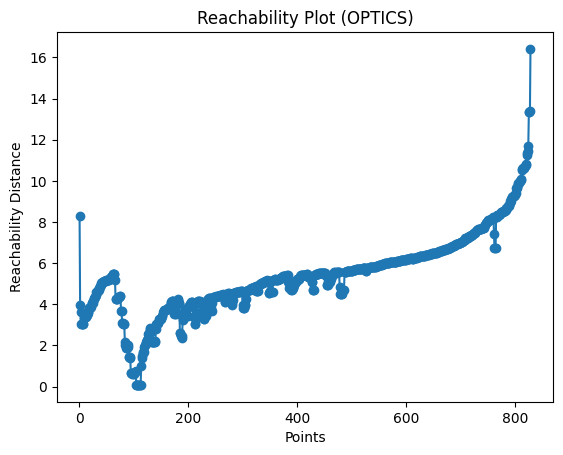

----------Running for day: 4 min_samples: 150, eps: 2-------------


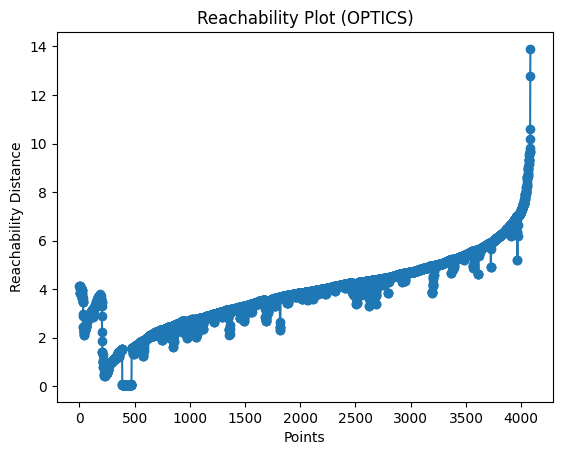

----------Running for day: 5 min_samples: 150, eps: 2-------------


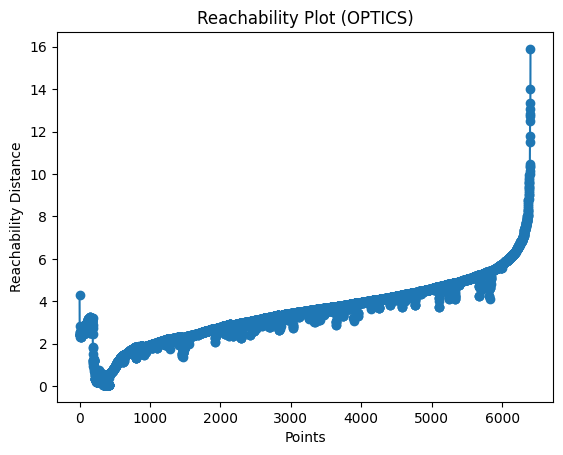

----------Running for day: 6 min_samples: 150, eps: 2-------------


KeyboardInterrupt: 

In [27]:
for day in days[0:5]:
    
    silhouette_score_DBSCAN = {}
    CH_score_DBSCAN = {}
    DB_score_DBSCAN = {}
    
    df_day = df_ae[df_ae['day'].isin([day])]
    X_day = np.asarray(df_day.loc[:,"0":"5183"])
    
    Normalizer_ = Normalizer().fit(X_day)
    X_n = Normalizer_.transform(X_day)

    print(f"----------Running for day: {day}")

    optics = OPTICS(min_samples=5).fit(X_n)
    reachability = optics.reachability_[optics.ordering_]

    plt.plot(reachability, marker='o')
    plt.title("Reachability Plot (OPTICS)")
    plt.xlabel("Points")
    plt.ylabel("Reachability Distance")
    plt.show()

# OPTICS

In [ ]:
optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=20)
optics.fit(X)

# 🔹 Extraer etiquetas de los clusters detectados automáticamente
labels = optics.labels_  # -1 indica ruido

# 🔹 Visualizar resultados
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="plasma", s=10)
plt.title("Clustering con OPTICS (sin eps, usando xi)")
plt.colorbar(label="Cluster ID")
plt.show()

# DBSCAN Normal

----------Running for day: 3 min_samples: 5, eps: 0.1-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 3 min_samples: 5, eps: 0.2-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 3 min_samples: 5, eps: 0.5-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 3 min_samples: 5, eps: 0.75-------------
Silhouette: {'eps_0.1_min_samples_5': None, 'eps_0.2_min_samples_5': None, 'eps_0.5_min_samples_5': None, 'eps_0.75_min_samples_5': 0.056127021804579874}, DB: {'eps_0.1_min_samples_5': None, 'eps_0.2_min_samples_5': None, 'eps_0.5_min_samples_5': None, 'eps_0.75_min_samples_5': 0.8271621589963528}, CH: {'eps_0.1_min_samples_5': None, 'eps_0.2_min_samples_5': None, 'eps_0.5_min_samples_5': None, 'eps_0.75_min_samples_5': 15.334592821417253}, DPVC: {'eps_0.75_min_samples_5': 0.34526054777670195}
For n_clusters = 2 The av

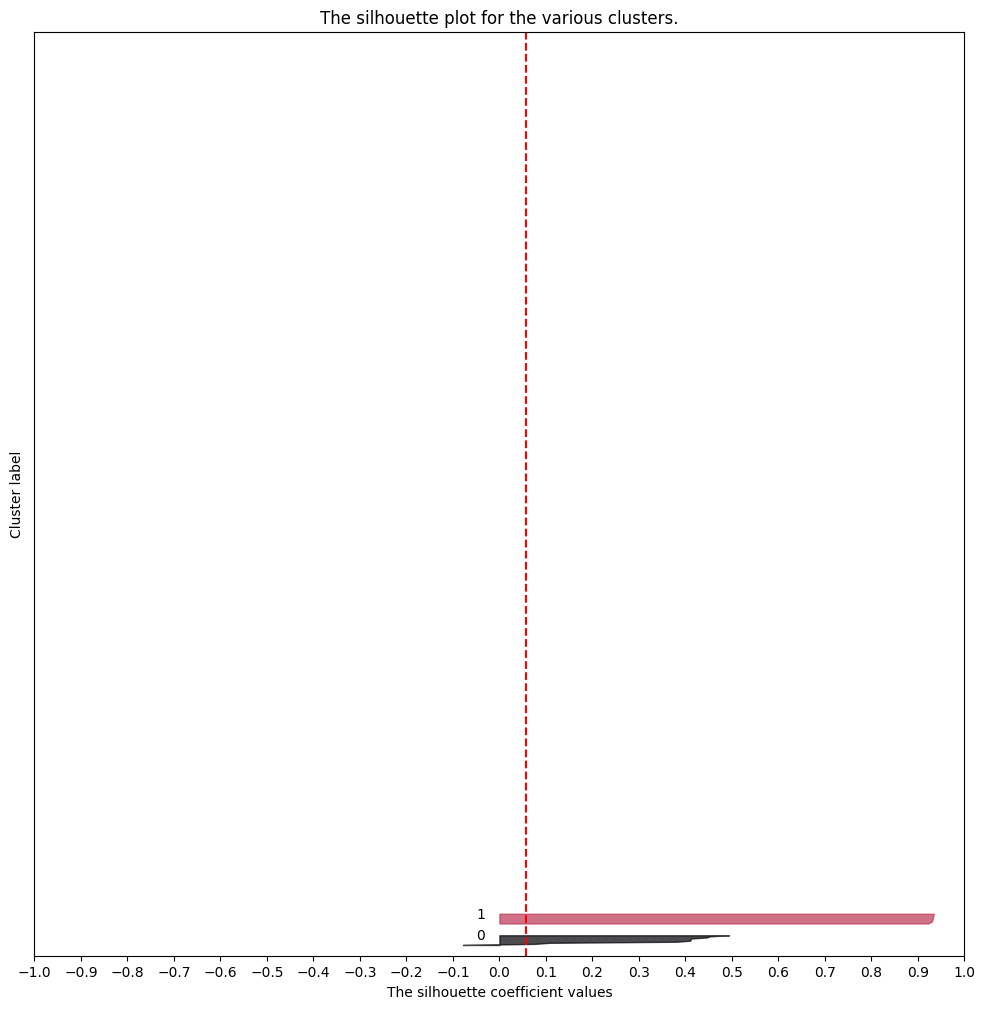

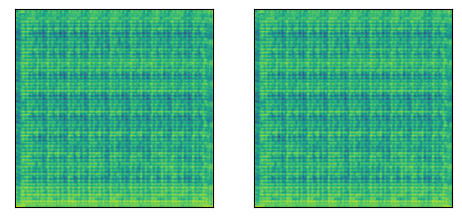

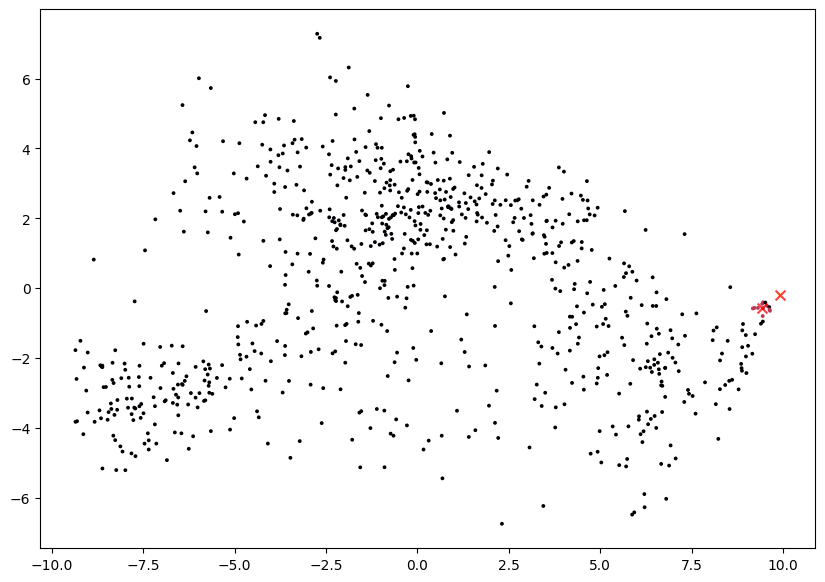

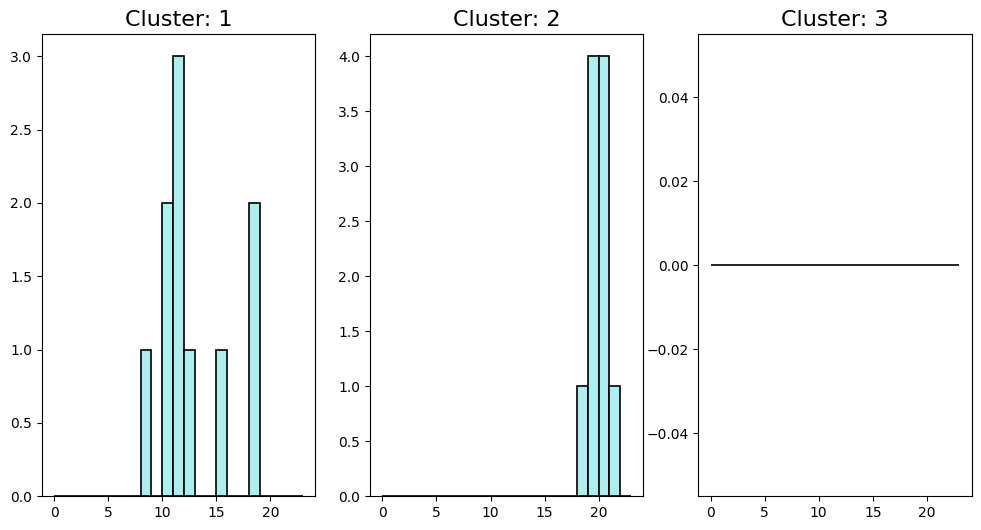

----------Running for day: 3 min_samples: 5, eps: 1-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 3 min_samples: 5, eps: 2-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 3 min_samples: 5, eps: 10-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 3 min_samples: 5, eps: 20-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 3 min_samples: 5, eps: 200-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 3 min_samples: 25, eps: 0.1-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 3 min_samples: 25, eps: 0.2-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 3 min_samples: 25, eps: 0

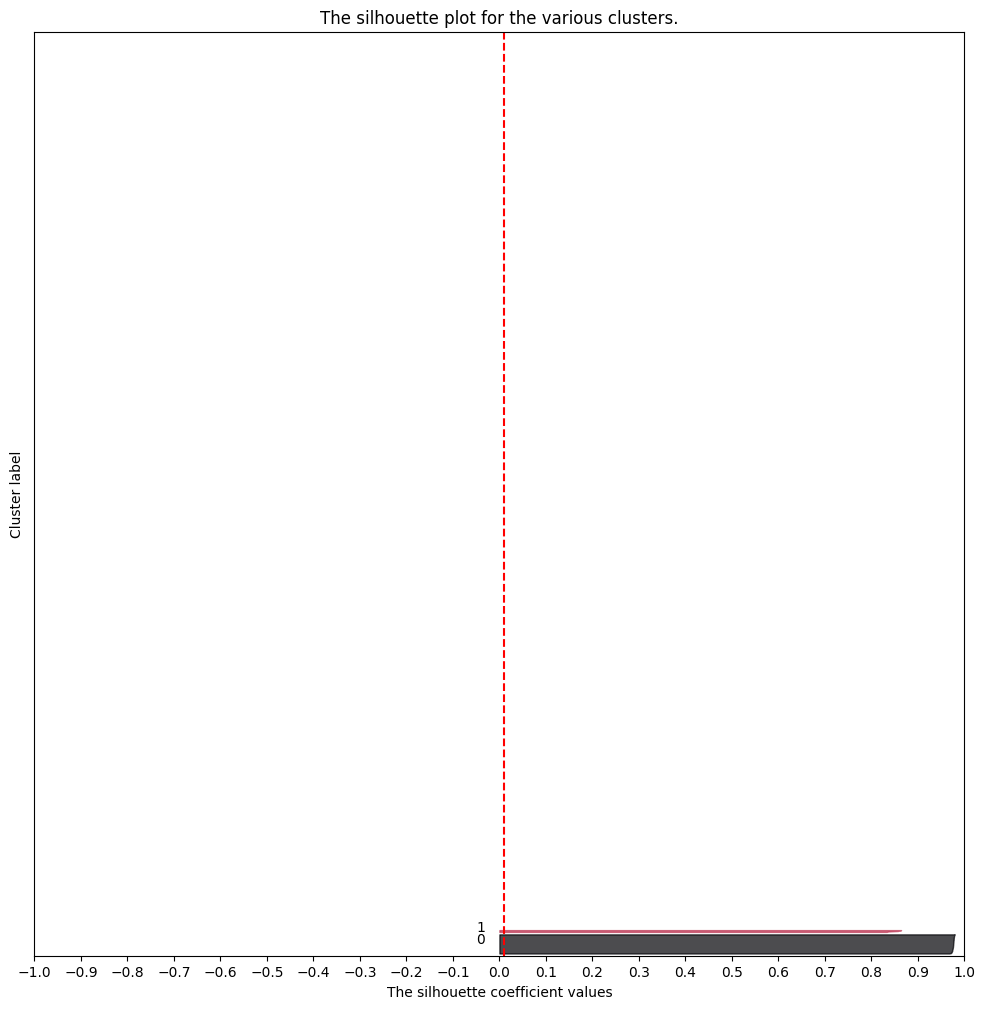

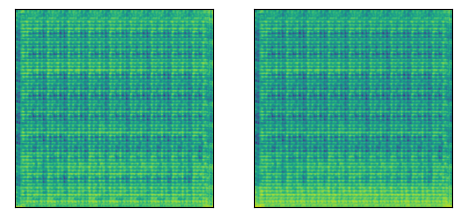

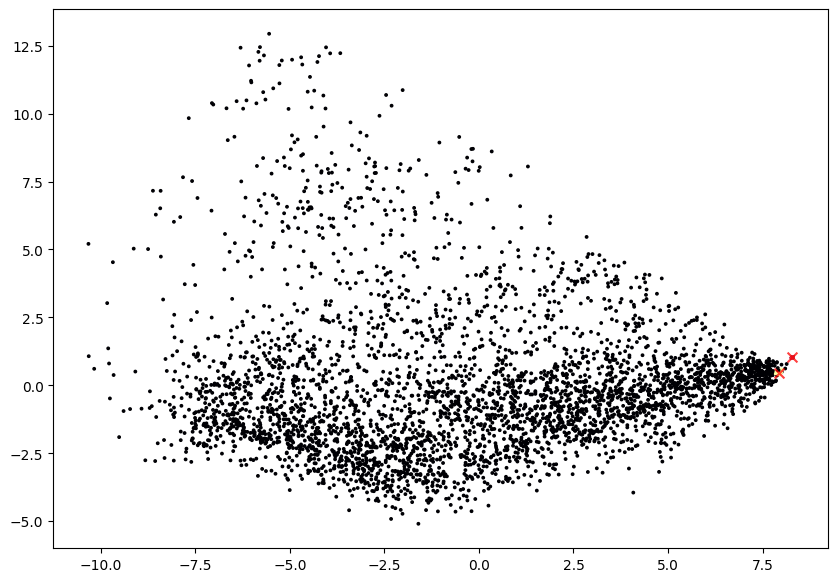

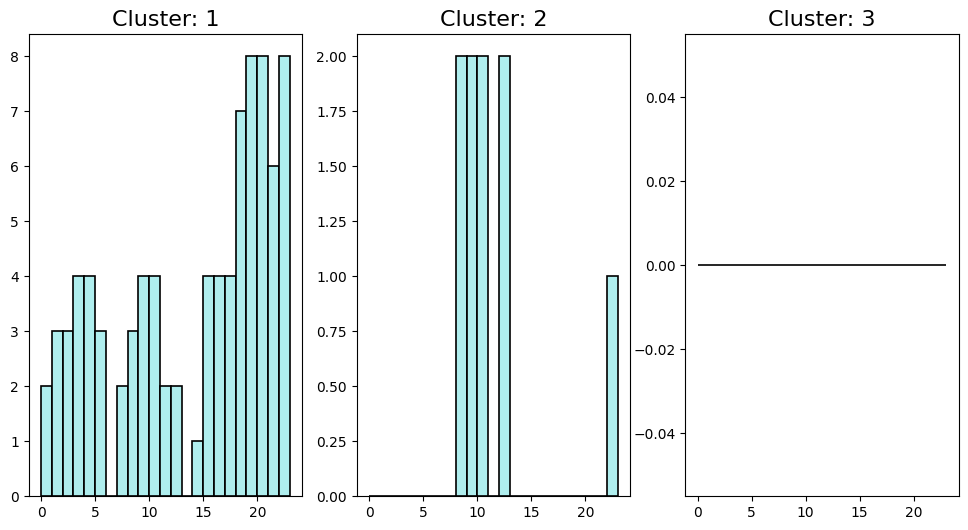

----------Running for day: 4 min_samples: 5, eps: 0.75-------------
Silhouette: {'eps_0.1_min_samples_5': None, 'eps_0.2_min_samples_5': None, 'eps_0.5_min_samples_5': 0.009936008470338011, 'eps_0.75_min_samples_5': -0.0017693280055764546}, DB: {'eps_0.1_min_samples_5': None, 'eps_0.2_min_samples_5': None, 'eps_0.5_min_samples_5': 0.8643460919852749, 'eps_0.75_min_samples_5': 0.9040211970559577}, CH: {'eps_0.1_min_samples_5': None, 'eps_0.2_min_samples_5': None, 'eps_0.5_min_samples_5': 70.54367395835745, 'eps_0.75_min_samples_5': 54.56538610479251}, DPVC: {'eps_0.5_min_samples_5': 0.24302099048091852, 'eps_0.75_min_samples_5': 0.4146078063170864}
For n_clusters = 3 The average silhouette_score is : -0.0017693280055764546


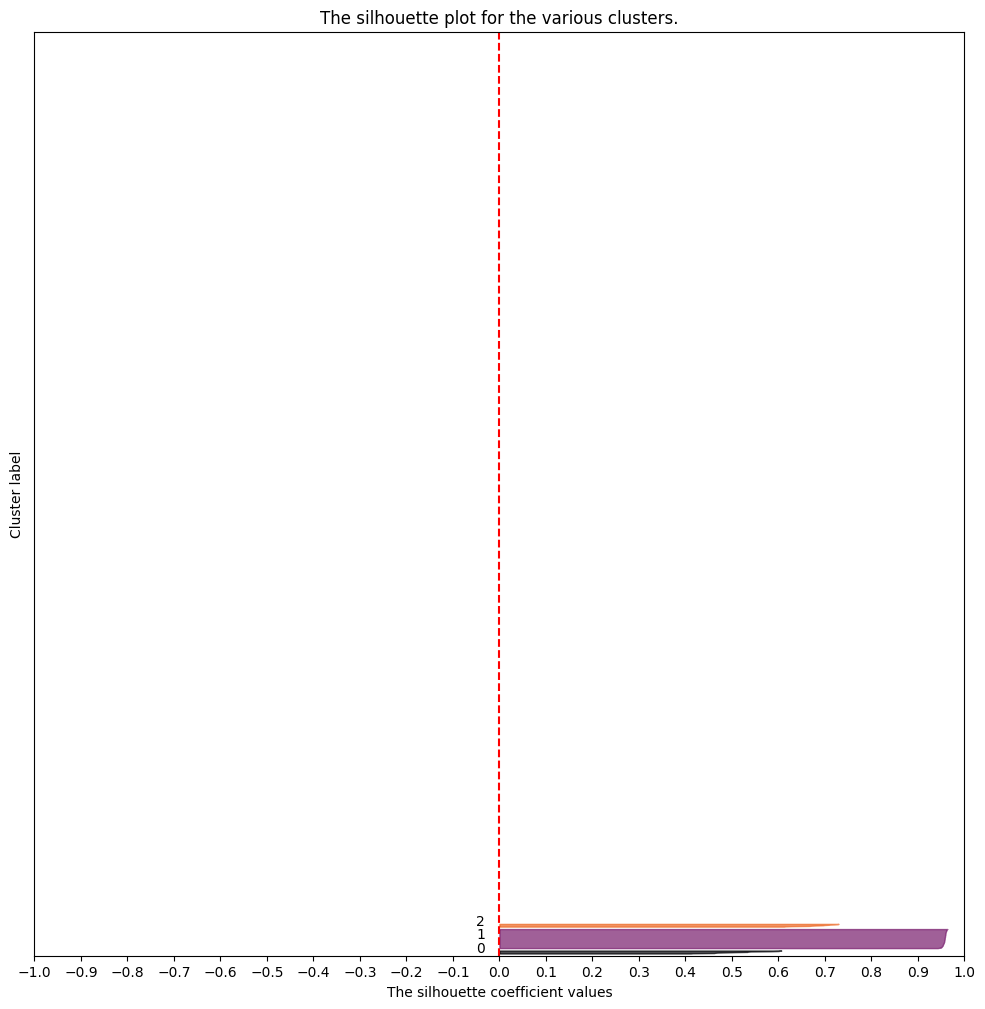

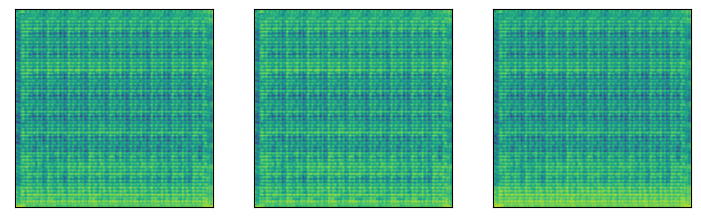

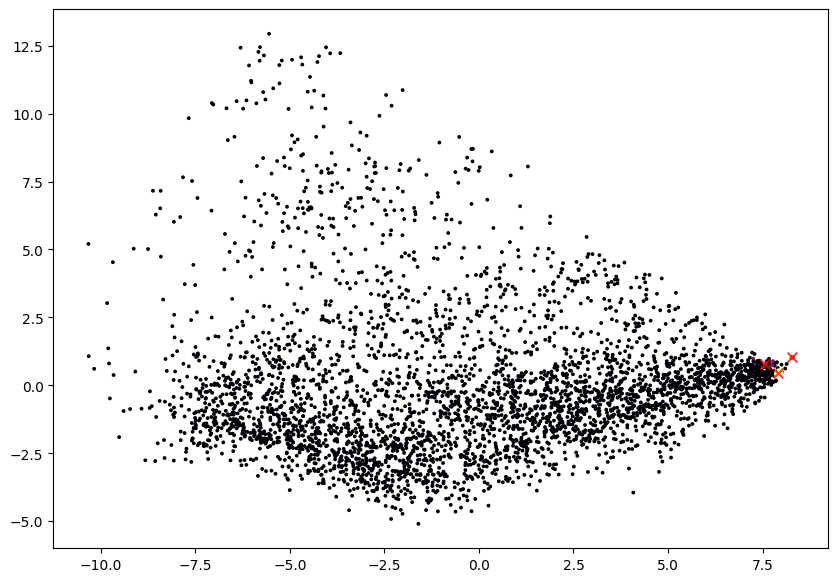

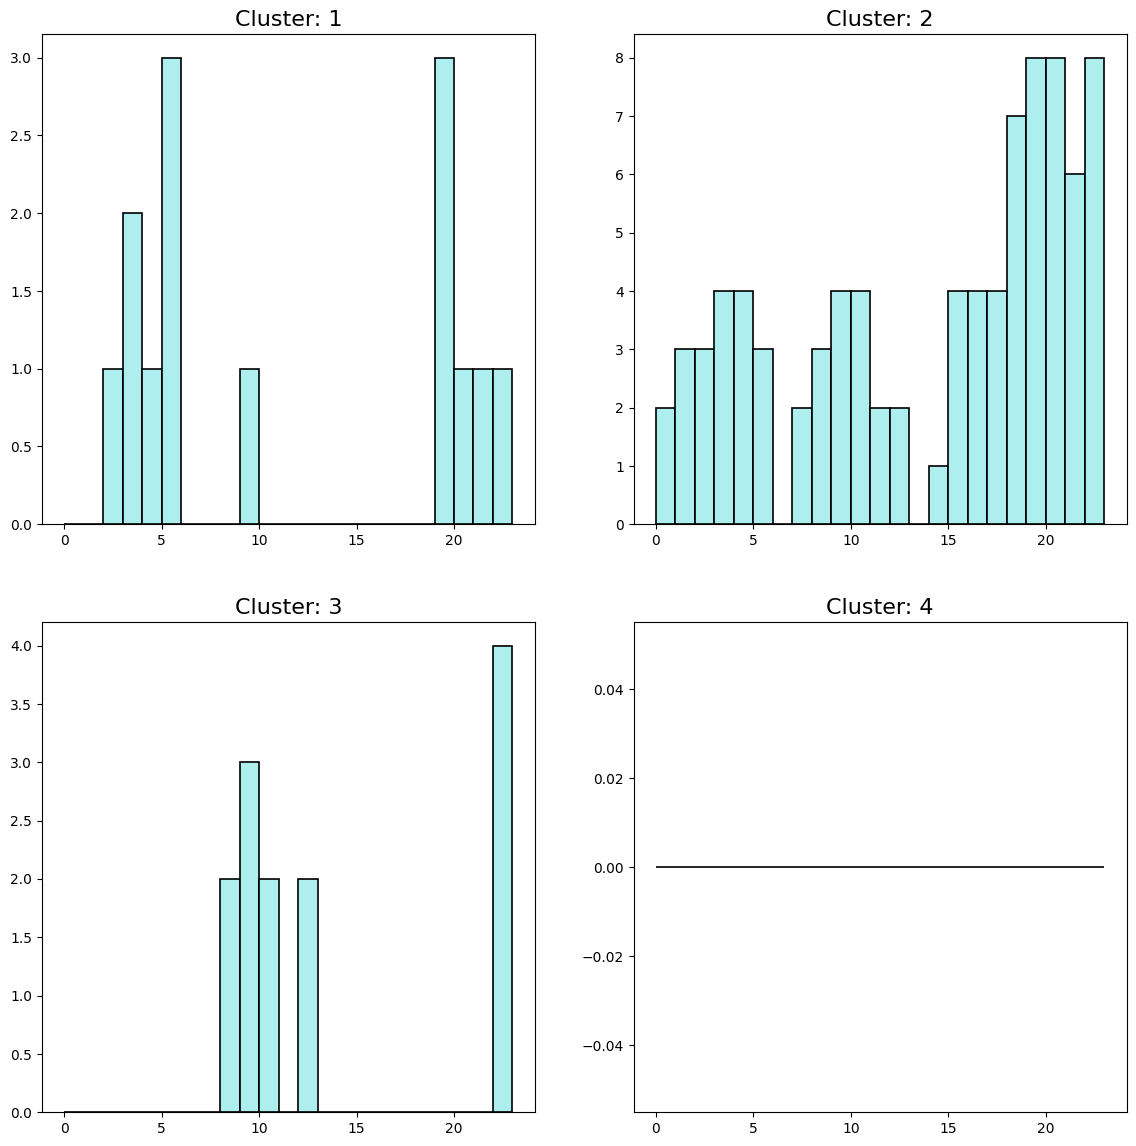

----------Running for day: 4 min_samples: 5, eps: 1-------------
Silhouette: {'eps_0.1_min_samples_5': None, 'eps_0.2_min_samples_5': None, 'eps_0.5_min_samples_5': 0.009936008470338011, 'eps_0.75_min_samples_5': -0.0017693280055764546, 'eps_1_min_samples_5': 0.014552524635260319}, DB: {'eps_0.1_min_samples_5': None, 'eps_0.2_min_samples_5': None, 'eps_0.5_min_samples_5': 0.8643460919852749, 'eps_0.75_min_samples_5': 0.9040211970559577, 'eps_1_min_samples_5': 0.9436890754914096}, CH: {'eps_0.1_min_samples_5': None, 'eps_0.2_min_samples_5': None, 'eps_0.5_min_samples_5': 70.54367395835745, 'eps_0.75_min_samples_5': 54.56538610479251, 'eps_1_min_samples_5': 113.54450485471257}, DPVC: {'eps_0.5_min_samples_5': 0.24302099048091852, 'eps_0.75_min_samples_5': 0.4146078063170864, 'eps_1_min_samples_5': 0.7576432593785908}
For n_clusters = 2 The average silhouette_score is : 0.014552524635260319


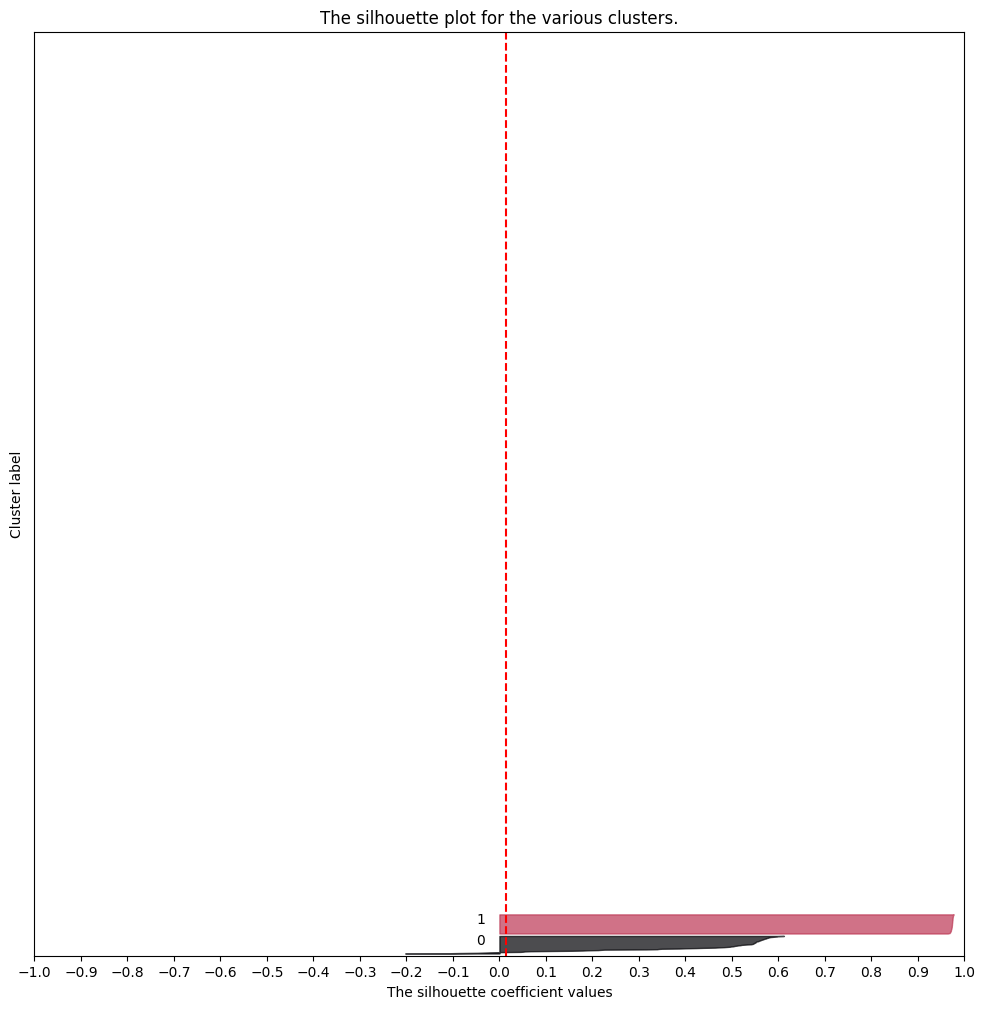

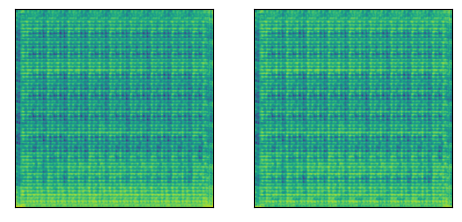

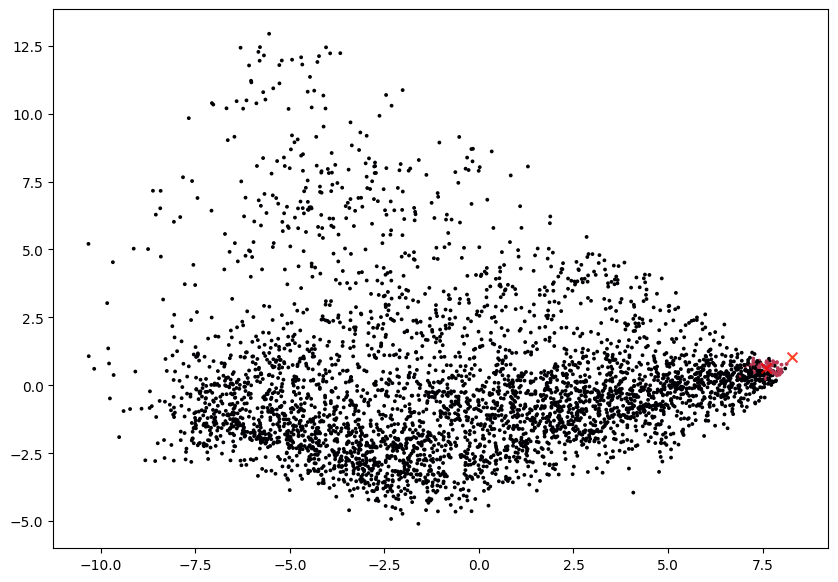

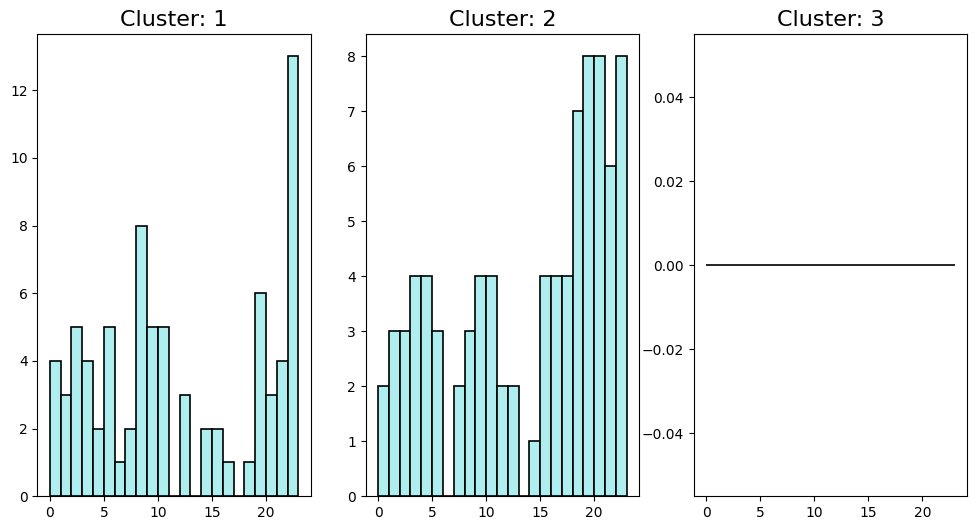

----------Running for day: 4 min_samples: 5, eps: 2-------------
Silhouette: {'eps_0.1_min_samples_5': None, 'eps_0.2_min_samples_5': None, 'eps_0.5_min_samples_5': 0.009936008470338011, 'eps_0.75_min_samples_5': -0.0017693280055764546, 'eps_1_min_samples_5': 0.014552524635260319, 'eps_2_min_samples_5': -0.12976130026928137}, DB: {'eps_0.1_min_samples_5': None, 'eps_0.2_min_samples_5': None, 'eps_0.5_min_samples_5': 0.8643460919852749, 'eps_0.75_min_samples_5': 0.9040211970559577, 'eps_1_min_samples_5': 0.9436890754914096, 'eps_2_min_samples_5': 1.3364857272495179}, CH: {'eps_0.1_min_samples_5': None, 'eps_0.2_min_samples_5': None, 'eps_0.5_min_samples_5': 70.54367395835745, 'eps_0.75_min_samples_5': 54.56538610479251, 'eps_1_min_samples_5': 113.54450485471257, 'eps_2_min_samples_5': 117.31122259518747}, DPVC: {'eps_0.5_min_samples_5': 0.24302099048091852, 'eps_0.75_min_samples_5': 0.4146078063170864, 'eps_1_min_samples_5': 0.7576432593785908, 'eps_2_min_samples_5': 2.0524407404875626}

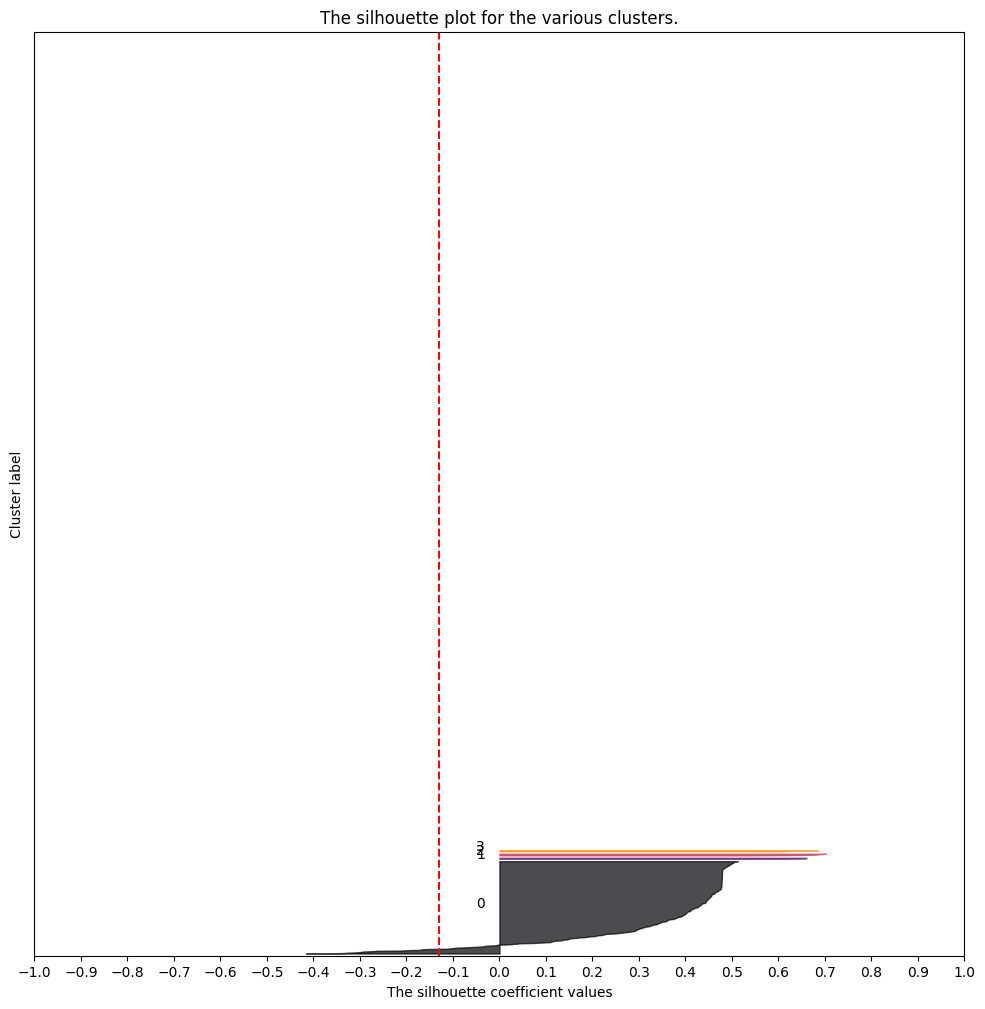

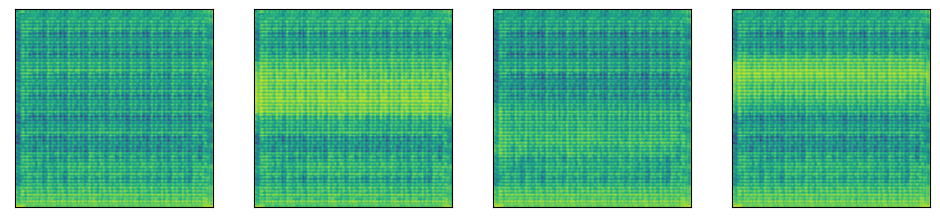

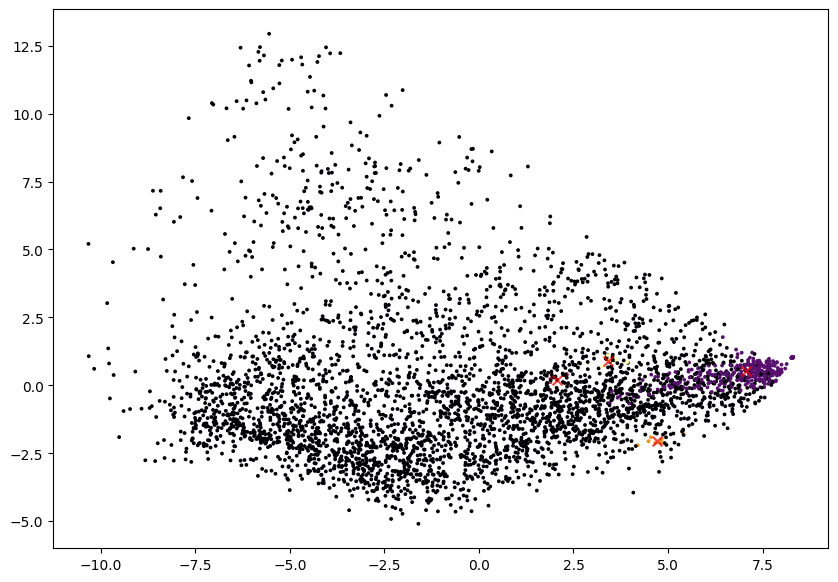

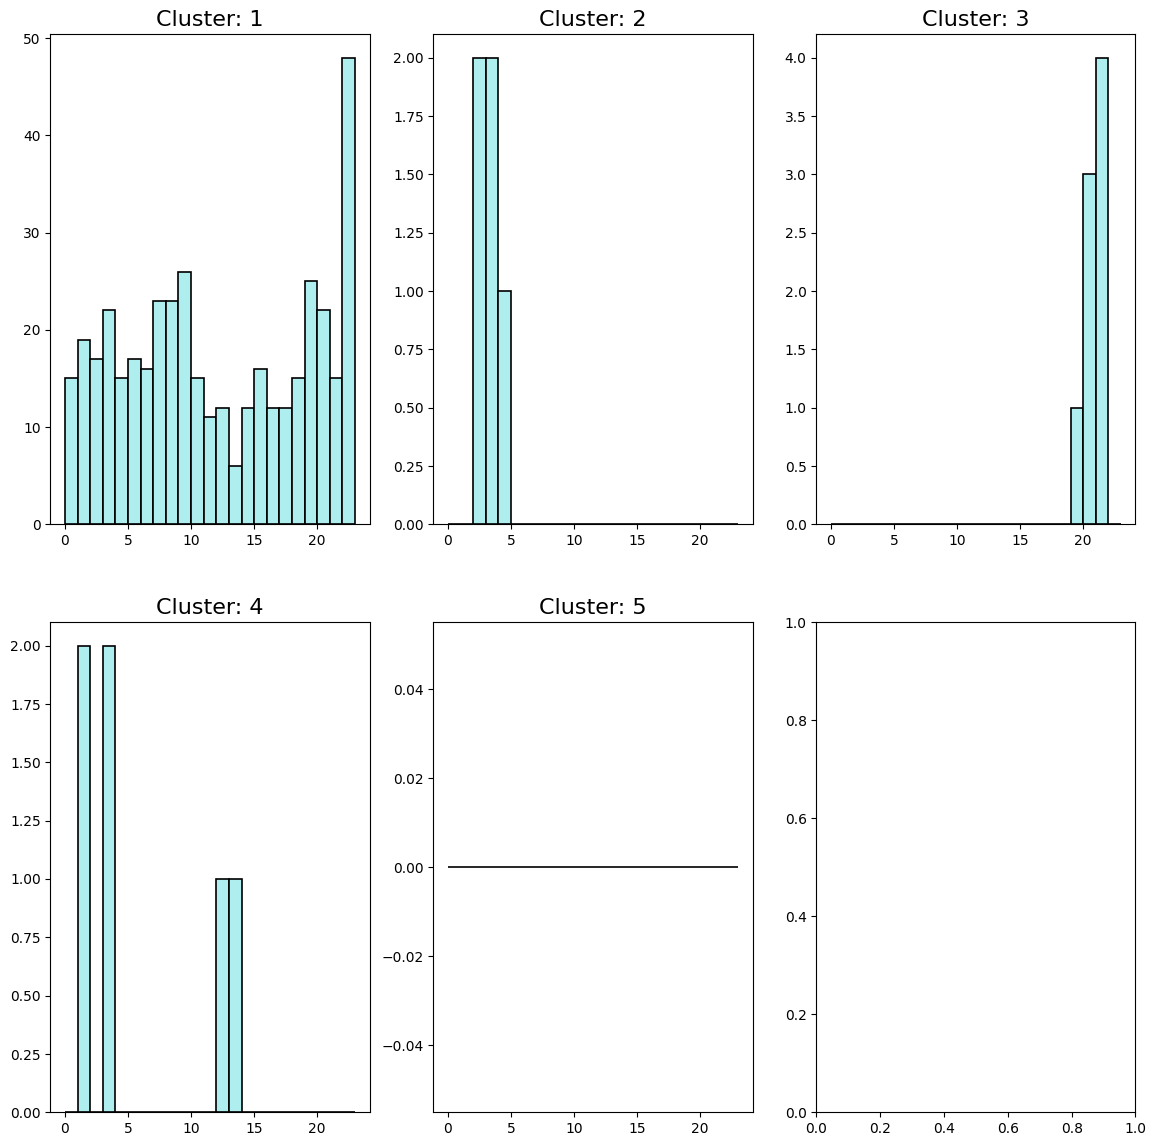

----------Running for day: 4 min_samples: 5, eps: 10-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 5, eps: 20-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 5, eps: 200-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 25, eps: 0.1-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 25, eps: 0.2-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 25, eps: 0.5-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 25, eps: 0.75-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 25,

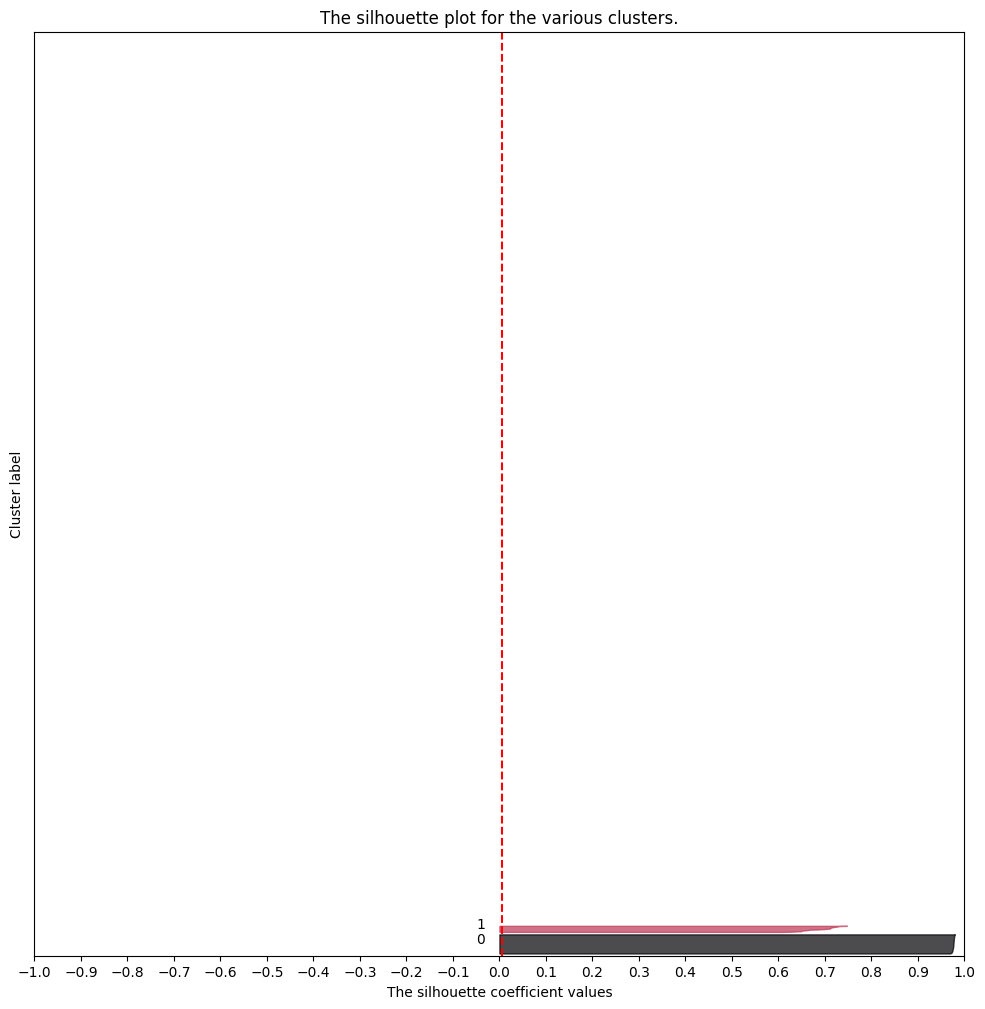

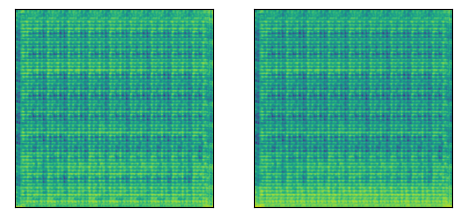

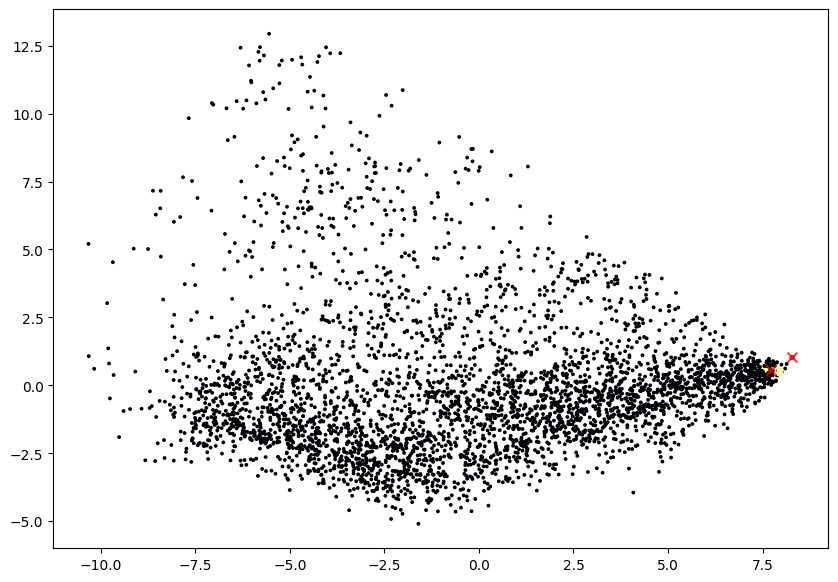

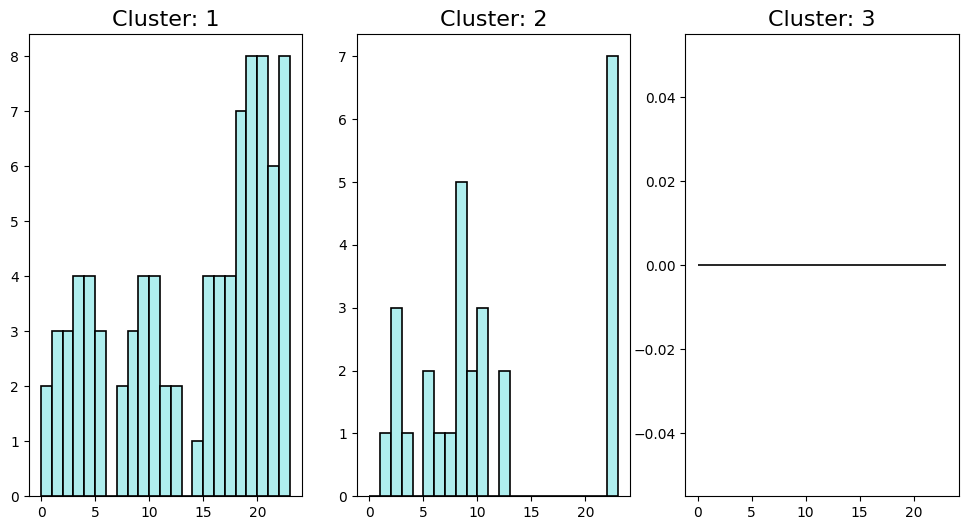

----------Running for day: 4 min_samples: 25, eps: 2-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 25, eps: 10-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 25, eps: 20-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 25, eps: 200-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 150, eps: 0.1-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 150, eps: 0.2-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 150, eps: 0.5-------------
Not working with these eps and min_samples values - Only one cluster
----------Running for day: 4 min_samples: 

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.metrics import pairwise_distances

# Definir parámetros para DBSCAN (eps y min_samples)
eps = [0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1, 1.5]  # Distancia máxima para que dos puntos sean considerados vecinos
min_samples = [5, 25, 150, 300, 500, 1000]  # Número mínimo de puntos para formar un cluster

for day in days[0:2]:
    
    silhouette_score_DBSCAN = {}
    CH_score_DBSCAN = {}
    DB_score_DBSCAN = {}
    DPVC_score_DBSCAN = {}
    
    df_day = df_ae[df_ae['day'].isin([day])]
    X_day = np.asarray(df_day.loc[:,"0":"5183"])
    
    Normalizer_ = Normalizer().fit(X_day)
    X_n = Normalizer_.transform(X_day)

    # Iterar a través de los valores de parámetros para DBSCAN (si quieres hacer varias pruebas con distintos eps)
    for id_, min_sample in enumerate(min_samples):  # clusters ahora contiene posibles combinaciones de eps y min_samples
        for ep in eps:

            print(f"----------Running for day: {day} min_samples: {min_sample}, eps: {ep}-------------")
                       

            DBSCAN_model = DBSCAN(eps=ep, min_samples=min_sample).fit(X_n)

            # Obtener las etiquetas de los clusters
            labels = DBSCAN_model.labels_

            # Filtrar etiquetas válidas (excluyendo ruido etiquetado como -1)
            unique_labels = set(labels)
            n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Excluir el ruido

            # Verificar si el algoritmo ha encontrado más de un cluster válido (excluyendo el ruido)
            if n_clusters > 1 and n_clusters<30:
                # Calcular las métricas solo si se ha formado más de un cluster
                silhouette_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = metrics.silhouette_score(X_n, labels)
                DB_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = DB(X_n, labels)
                CH_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = CH(X_n, labels)
                DPVC_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = dpvc(X_n, labels)

                print(f"Silhouette: {silhouette_score_DBSCAN}, DB: {DB_score_DBSCAN}, CH: {CH_score_DBSCAN}, DPVC: {DPVC_score_DBSCAN}")

                # Graficar el silhouette plot
                plot_silhouette(X_n, labels, n_clusters, silhouette_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"],
                                method=f"DBSCAN", 
                                extra= f"eps_{DBSCAN_model.eps}_min_samples_{DBSCAN_model.min_samples}",
                                save=True,
                               root=f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_Normal/{day}")

                # Calcular los centroides de cada cluster (excluyendo los puntos de ruido etiquetados como -1)
                cluster_centers = np.array([X_n[labels == label].mean(axis=0) for label in unique_labels if label != -1])

                # Asignar los centroides como atributo del modelo DBSCAN
                DBSCAN_model.centroids = cluster_centers  # Aquí agregamos el nuevo atributo

                # Graficar los centroides
    #             cluster_centers_inverse = mapper.inverse_transform(cluster_centers)
                plot_centroids(cluster_centers, testing, f"eps_{DBSCAN_model.eps}_min_samples_{DBSCAN_model.min_samples}",
                                save=True, 
                               root=f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_Normal/{day}/")

                pca = PCA(n_components=2)
                X_pca = pca.fit_transform(X_n)  # Reducir las dimensiones a 2
                plt.figure(figsize=(10, 7))
                plt.scatter(X_pca[:, 0], X_pca[:, 1], c=DBSCAN_model.labels_, cmap='inferno', alpha=1, s=3)
    #             plt.scatter(X_n[:, 0], X_n[:, 1], c=DBSCAN_model.labels_, cmap='inferno', alpha=0.2, s=1)
                centroids_pca = pca.transform(cluster_centers)
                plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=50, alpha=0.75, marker='x')
    #             plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50, alpha=0.75, marker='x')
                plt.savefig(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_Normal/{day}/Scatter_DBSCAN_eps_{ep}_min_samples_{min_sample}.png")

                # Generar resultados del clustering usando la clase ClusteringResults
                DBSCAN_Results = ClusteringResults(DBSCAN_model, df_ae, y_label="hour", hist_library="plt")
                DBSCAN_Results.histograms(extra=f"eps_{DBSCAN_model.eps}_min_samples_{DBSCAN_model.min_samples}",
                                          save=True, 
                                          root =f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_Normal/{day}/")
    #     #         DBSCAN_Results.joyplot()
            elif n_clusters<=1:
                print(f"Not working with these eps and min_samples values - Only one cluster")
                silhouette_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = None
                DB_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = None
                CH_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = None
                DPVC_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = None
                continue
                
            else:
                print(f"Not working with these eps and min_samples values - Many clusters")
                silhouette_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = metrics.silhouette_score(X_n, labels)
                DB_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = DB(X_n, labels)
                CH_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = CH(X_n, labels)
                DPVC_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = dpvc(X_n, labels)
                continue
        #         print(f"DBSCAN no encontró suficientes clusters para eps={eps_value} y min_samples={min_samples_value}")

        # Guardar los resultados en archivos pickle
    with open(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_Normal/{day}/silhouette_eps_{eps}_min_samples_{min_samples}", "wb") as file:
        pkl.dump(silhouette_score_DBSCAN, file)
    with open(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_Normal/{day}/DB_eps_{eps}_min_samples_{min_samples}", "wb") as file:
        pkl.dump(DB_score_DBSCAN, file)
    with open(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_Normal/{day}/CH_eps_{eps}_min_samples_{min_samples}", "wb") as file:
        pkl.dump(CH_score_DBSCAN, file)

# DBSCAN UMAP

In [ ]:
from sklearn.cluster import DBSCAN

# Definir parámetros para DBSCAN (eps y min_samples)
eps = [0.1, 0.5, 0.75, 1, 2, 10, 20, 200]  # Distancia máxima para que dos puntos sean considerados vecinos
min_samples = [5, 25, 150, 300, 500]  # Número mínimo de puntos para formar un cluster

for day in days:
    
    silhouette_score_DBSCAN = {}
    CH_score_DBSCAN = {}
    DB_score_DBSCAN = {}
    
    df_day = df_ae[df_ae['day'].isin([day])]
    X_day = np.asarray(df_day.loc[:,"0":"5183"])
    
    Normalizer_ = Normalizer().fit(X_day)
    X_n = Normalizer_.transform(X_day)
    
    mapper = umap.UMAP(n_components=2, min_dist=0.01,
                            metric="euclidean", n_neighbors=75,
                            random_state=0, n_jobs=-1).fit(X_n) 
    X_UMAP = mapper.transform(X_n)
    X_n = X_UMAP

    # Iterar a través de los valores de parámetros para DBSCAN (si quieres hacer varias pruebas con distintos eps)
    for id_, min_sample in enumerate(min_samples):  # clusters ahora contiene posibles combinaciones de eps y min_samples
        for ep in eps:

            print(f"----------Running for day: {day} min_samples: {min_sample}, eps: {ep}-------------")


            DBSCAN_model = DBSCAN(eps=ep, min_samples=min_sample).fit(X_n)

            # Obtener las etiquetas de los clusters
            labels = DBSCAN_model.labels_

            # Filtrar etiquetas válidas (excluyendo ruido etiquetado como -1)
            unique_labels = set(labels)
            n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Excluir el ruido

            # Verificar si el algoritmo ha encontrado más de un cluster válido (excluyendo el ruido)
            if n_clusters > 1 and n_clusters<30:
                # Calcular las métricas solo si se ha formado más de un cluster
                silhouette_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = metrics.silhouette_score(X_n, labels)
                DB_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = DB(X_n, labels)
                CH_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = CH(X_n, labels)

                print(f"Silhouette: {silhouette_score_DBSCAN}, DB: {DB_score_DBSCAN}, CH: {CH_score_DBSCAN}")

                # Graficar el silhouette plot
                plot_silhouette(X_n, labels, n_clusters, silhouette_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"],
                                method=f"DBSCAN", 
                                extra= f"eps_{DBSCAN_model.eps}_min_samples_{DBSCAN_model.min_samples}",
                                save=True,
                               root=f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_UMAP/{day}")

                # Calcular los centroides de cada cluster (excluyendo los puntos de ruido etiquetados como -1)
                cluster_centers = np.array([X_n[labels == label].mean(axis=0) for label in unique_labels if label != -1])

                # Asignar los centroides como atributo del modelo DBSCAN
                DBSCAN_model.centroids = cluster_centers  # Aquí agregamos el nuevo atributo

                # Graficar los centroides
                cluster_centers_inverse = mapper.inverse_transform(cluster_centers)
                plot_centroids(cluster_centers_inverse, testing, f"eps_{DBSCAN_model.eps}_min_samples_{DBSCAN_model.min_samples}",
                                save=True, 
                               root=f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_UMAP/{day}/")

#                 pca = PCA(n_components=2)
#                 X_pca = pca.fit_transform(X_n)  # Reducir las dimensiones a 2
#                 plt.figure(figsize=(10, 7))
#                 plt.scatter(X_pca[:, 0], X_pca[:, 1], c=DBSCAN_model.labels_, cmap='inferno', alpha=1, s=3)
                plt.scatter(X_n[:, 0], X_n[:, 1], c=DBSCAN_model.labels_, cmap='inferno', alpha=0.2, s=1)
#                 centroids_pca = pca.transform(cluster_centers)
#                 plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=50, alpha=0.75, marker='x')
                plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50, alpha=0.75, marker='x')
                plt.savefig(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_UMAP/{day}/Scatter_DBSCAN_eps_{ep}_min_samples_{min_sample}.png")

                # Generar resultados del clustering usando la clase ClusteringResults
                DBSCAN_Results = ClusteringResults(DBSCAN_model, df_ae, y_label="hour", hist_library="plt")
                DBSCAN_Results.histograms(extra=f"eps_{DBSCAN_model.eps}_min_samples_{DBSCAN_model.min_samples}",
                                          save=True, 
                                          root =f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_UMAP/{day}/")
    #     #         DBSCAN_Results.joyplot()
            elif n_clusters<=1:
                print(f"Not working with these eps and min_samples values - Only one cluster")
                silhouette_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = None
                DB_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = None
                CH_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = None
                continue
                
            else:
                print(f"Not working with these eps and min_samples values - Many clusters")
                silhouette_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = metrics.silhouette_score(X_n, labels)
                DB_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = DB(X_n, labels)
                CH_score_DBSCAN[f"eps_{ep}_min_samples_{min_sample}"] = CH(X_n, labels)
                continue

        # Guardar los resultados en archivos pickle
    with open(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_UMAP/{day}/silhouette_eps_{eps}_min_samples_{min_samples}", "wb") as file:
        pkl.dump(silhouette_score_DBSCAN, file)
    with open(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_UMAP/{day}/DB_eps_{eps}_min_samples_{min_samples}", "wb") as file:
        pkl.dump(DB_score_DBSCAN, file)
    with open(f"temporal_zamuro/zamuro_clustering_results/Days_Results/AE/DBSCAN_UMAP/{day}/CH_eps_{eps}_min_samples_{min_samples}", "wb") as file:
        pkl.dump(CH_score_DBSCAN, file)

# HDBSCAN

In [ ]:
import hdbscan
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import metrics

# Inicializamos las listas de scores
silhouette_score_HDBSCAN = {}
DB_score_HDBSCAN = {}
CH_score_HDBSCAN = {}

X_norm = X

# Parámetros para HDBSCAN
min_samples = [5, 25, 150]  # Número mínimo de puntos en cada cluster
min_cluster_sizes = [2, 5, 10, 25, 50]  # Tamaño mínimo de los clusters

# Iterar a través de los valores de parámetros para HDBSCAN
for id_, min_sample in enumerate(min_samples):
    for min_cluster_size in min_cluster_sizes:
        
        print(f"Running for min_samples: {min_sample}, min_cluster_size: {min_cluster_size}")
    
        # Ajustar el modelo HDBSCAN
        HDBSCAN_model = hdbscan.HDBSCAN(min_samples=min_sample, min_cluster_size=min_cluster_size).fit(X_norm)

        # Obtener las etiquetas de los clusters
        labels = HDBSCAN_model.labels_

        # Filtrar etiquetas válidas (excluyendo ruido etiquetado como -1)
        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # Excluir el ruido

        # Verificar si el algoritmo ha encontrado más de un cluster válido (excluyendo el ruido)
        if n_clusters > 1 and n_clusters < 31:
            # Calcular las métricas solo si se ha formado más de un cluster
            silhouette_score_HDBSCAN[f"min_cluster_size_{min_cluster_size}_min_samples_{min_sample}"] = metrics.silhouette_score(X_norm, labels)
            DB_score_HDBSCAN[f"min_cluster_size_{min_cluster_size}_min_samples_{min_sample}"] = DB(X_norm, labels)
            CH_score_HDBSCAN[f"min_cluster_size_{min_cluster_size}_min_samples_{min_sample}"] = CH(X_norm, labels)

            print(f"Silhouette: {silhouette_score_HDBSCAN}, DB: {DB_score_HDBSCAN}, CH: {CH_score_HDBSCAN}")

            # Graficar el silhouette plot
            plot_silhouette(X_norm, labels, n_clusters, silhouette_score_HDBSCAN[f"min_cluster_size_{min_cluster_size}_min_samples_{min_sample}"],
                            save=True,
                           root=f"temporal_zamuro/zamuro_clustering_results/HDBSCAN_Normal/")

            # Calcular los "centroides" aproximados de cada cluster (excluyendo ruido)
            cluster_centers = np.array([X_norm[labels == label].mean(axis=0) for label in unique_labels if label != -1])

            # Asignar los centroides como atributo del modelo HDBSCAN
#             cluster_centers_inverse = mapper.inverse_transform(cluster_centers)
            HDBSCAN_model.centroids = cluster_centers  # Aquí agregamos el nuevo atributo

#             Graficar los centroides
            plot_centroids(cluster_centers, testing, f"min_cluster_size_{HDBSCAN_model.min_cluster_size}_min_samples_{HDBSCAN_model.min_samples}",
                            save=True,
                           root=f"temporal_zamuro/zamuro_clustering_results/HDBSCAN_Normal/")
            
            # Proyección PCA para visualización
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X_norm)  # Reducir las dimensiones a 2
            plt.figure(figsize=(10, 7))
            plt.scatter(X_pca[:, 0], X_pca[:, 1], c=HDBSCAN_model.labels_, cmap='inferno', alpha=0.2, s=1)
#             plt.scatter(X_norm[:, 0], X_norm[:, 1], c=HDBSCAN_model.labels_, cmap='inferno', alpha=0.2, s=1)
            plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50, alpha=0.75, marker='x')
            plt.savefig(f"temporal_zamuro/zamuro_clustering_results/HDBSCAN_Normal/Scatter_HDBSCAN_min_cluster_size_{min_cluster_size}_min_samples_{min_sample}")
            
            # Transformar los centroides a la proyección PCA
            centroids_pca = pca.transform(cluster_centers)
            plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=50, alpha=0.75, marker='x')

#             plt.title(f'HDBSCAN clustering with min_samples={min_sample}, min_cluster_size={min_cluster_size} (PCA projection)')
#             plt.xlabel('PCA Component 1')
#             plt.ylabel('PCA Component 2')
#             plt.colorbar(label='Cluster label')
#             plt.show()

            # Generar resultados del clustering usando la clase ClusteringResults
            HDBSCAN_Results = ClusteringResults(HDBSCAN_model, df_ae, y_label="hour", hist_library="plt")
            HDBSCAN_Results.histograms(extra=f"min_cluster_size_{HDBSCAN_model.min_cluster_size}_min_samples_{HDBSCAN_model.min_samples}",
                                      save=True, 
                                      root =f"temporal_zamuro/zamuro_clustering_results/HDBSCAN_Normal/")  # root="temporal/clustering_results/HDBSCAN/")
    #         HDBSCAN_Results.joyplot()
        else:
            print(f"Not enough clusters found with these min_samples and min_cluster_size values")
            continue

    # Guardar los resultados en archivos pickle
with open(f"temporal_zamuro/zamuro_clustering_results/HDBSCAN_Normal/silhouette_min_samples_{min_sample}_min_cluster_size_{min_cluster_size}", "wb") as file:
    pkl.dump(silhouette_score_HDBSCAN, file)
with open(f"temporal_zamuro/zamuro_clustering_results/HDBSCAN_Normal/DB_min_samples_{min_sample}_min_cluster_size_{min_cluster_size}", "wb") as file:
    pkl.dump(DB_score_HDBSCAN, file)
with open(f"temporal_zamuro/zamuro_clustering_results/HDBSCAN_Normal/CH_min_samples_{min_sample}_min_cluster_size_{min_cluster_size}", "wb") as file:
    pkl.dump(CH_score_HDBSCAN, file)


## Cluster Extraction

In [ ]:
Clustering = KMeans(n_clusters=n_cluster, random_state=0).fit(X_norm)
Results = ClusteringResults(Clustering, df_ae, y_label="hour")
Results.


In [ ]:
plot_centroids(cluster_centers, testing, save=False)
            
            # Proyección PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)  # Reducir las dimensiones a 2
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=HDBSCAN_model.labels_, cmap='inferno', alpha=0.2, s=1)

# Transformar los centroides a la proyección PCA
centroids_pca = pca.transform(cluster_centers)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=50, alpha=0.75, marker='x')

plt.title(f'HDBSCAN clustering with min_samples={min_sample}, min_cluster_size={min_cluster_size} (PCA projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster label')
plt.show()

# Generar resultados del clustering usando la clase ClusteringResults
HDBSCAN_Results = ClusteringResults(HDBSCAN_model, df_ae, y_label="hour", hist_library="plt")
HDBSCAN_Results.histograms()  # root="temporal/clustering_results/HDBSCAN/")
#         HDBSCAN_Results.joyplot()

In [ ]:
f = Kmeans_Results.tagger(path_flat)
torch.save(f,f"temporal/clusters/kmeans_UMAP_clustering_labels_PosAE_rainless_{len(set(Kmeans.labels_))}")
leido= torch.load(f"Features/clustering_labels_clusters_3")

In [ ]:
def num_rows_cols(num_elements):
    num_rows = int(np.sqrt(num_elements))
    num_cols = (num_elements + num_rows - 1) // num_rows
    return num_rows, num_cols

def get_row_col(pos, cols):
    row = pos // cols
    col = pos % cols
    return row, col

class ClusteringResults:
    def __init__(self, model, df, y_label="hour", hist_library="plt"):
        self._labels_cluster = None
        self._n_labels = None
        self._label = y_label
        self._model = model
        self._n_clusters = len(set(model.labels_))
        self._y = df
        self._n_labels = set(list(self._y.loc[:,self._label]))
        
    def one_cluster_eval(self, cluster):
        index = np.where(self._model.labels_ == cluster)
        index = list(index[0])
        self._labels_cluster = self._y.loc[index, self._label]
        return list(self._labels_cluster)

    def tagger(self, samples):
        labels = []
        self._y["cluster"] = self._model.labels_
        for cluster in range(self._n_clusters):
            index = np.where(self._model.labels_ == cluster)
            index = index[0]
            labels.append(samples[index])
        return labels

    def joyplot(self, joy_vars=None):
        if joy_vars is None:
            joy_vars = ["hour", "location"]
        size_x = 8
        size_y = 6
        labels_cluster = []
        df = pd.DataFrame()
        for cluster in range(self._n_clusters):
            df = pd.DataFrame()
            for i, label in enumerate(joy_vars):
                labels_cluster.append(self.tagger(np.asarray(self._y[label])))
                df[label] = labels_cluster[i][cluster]

            if (self._label == "location"):
                joypy.joyplot(df, by="location", column="hour", range_style='own',
                              grid="y", hist=False, linewidth=1, legend=False, figsize=(size_x, size_y),
                              title=f"Cluster {cluster} \nLabels distribution along recorders using recorders as rows",
                              colormap=cm.autumn_r, fade=False)
            plt.xticks(fontsize=22)
            plt.yticks(fontsize=22)
            plt.show()

    def histograms(self, hist_library="plt", root=None, save=True):
        bins = list(self._n_labels)
        num_rows, num_cols = num_rows_cols(self._n_clusters)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))
        if self._n_clusters <= 3:
            axes = np.expand_dims(axes, 0)
            fig.set_figheight(6)
            fig.set_figwidth(12)
            if self._n_clusters == 1:
                axes = np.expand_dims(axes, 0)
            else:
                pass
        else:
            pass
        for hist in range(self._n_clusters):
            aux = self.one_cluster_eval(hist)
            ax_0, ax_1 = get_row_col(hist, num_cols)
            if hist_library == "plt":
                axes[ax_0][ax_1].hist(aux, histtype="bar",
                                      color="paleturquoise", cumulative=False,
                                      edgecolor='black',
                                      linewidth=1.2, bins=bins, stacked=False)
                axes[ax_0][ax_1].set_title(f"Cluster: {hist+1}", size=16)
            elif hist_library == "sns":
                sns.distplot(aux, bins=np.arange(aux.min(), aux.max() + 1),
                             hist_kws=dict(edgecolor="black", linewidth=1),
                             ax=axes[ax_0, ax_1])
                axes[ax_0][ax_1].set_title(f"Cluster: {hist+1}", size=16)
            else:
                raise Exception(f"Library {self._hist_library} unused")

            if (root is not None) & (save is True):
                plt.savefig(f"{root}/Histograms_plot_{self._n_clusters}.pdf", format="pdf")
            else:
                pass
        plt.show()
